In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
from jnkepler.jaxttv import *
from jnkepler.jaxttv.utils import elements_to_pdic, params_to_elements
from jax.config import config
import numpyro, jax
config.update('jax_enable_x64', True)
numpyro.set_platform('cpu')
num_chains = 1
numpyro.set_host_device_count(num_chains)
print ('# jax device count:', jax.local_device_count())

# jax device count: 1


In [2]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='times')
plt.rcParams["figure.figsize"] = (12,6)
from matplotlib import rc
rc('text', usetex=True*0)

In [3]:
d = pd.read_csv("kep51/ttv.txt", delim_whitespace=True, header=None, names=['tnum', 'tc', 'tcerr', 'dnum', 'planum'])
tcobs = [jnp.array(d.tc[d.planum==j+1]) for j in range(3)]
errorobs = [jnp.array(d.tcerr[d.planum==j+1]) for j in range(3)]
p_init = [45.155305, 85.31646, 130.17809]

In [4]:
import dill
mcmc = dill.load(open('kep51/dt1.0_nw500_ns1500_c4_mcmc.pkl', 'rb'))

In [5]:
samples = mcmc.get_samples()

In [6]:
M_earth = 3.0034893e-6
samples['pmass'] = samples['mass'] / M_earth

In [7]:
dt = 1.0
t_start, t_end = 155., 2950.
jttv = JaxTTV(t_start, t_end, dt) # jaxttv class
jttv.set_tcobs(tcobs, p_init, errorobs=errorobs, print_info=False)

### TTVFast parameters and models

In [8]:
from jnkepler.jaxttv.ttvfastutils import *
from jnkepler.jaxttv.utils import findidx_map

In [9]:
# dataframe containing parameter sets for TTVFast
pttvfast = params_for_ttvfast(samples, jttv.t_start, jttv.nplanet)

In [10]:
sidx = 0

In [11]:
_, tcs_tf = get_ttvfast_model(pttvfast.iloc[sidx], jttv.nplanet, t_start, p_init[0]/5e3, t_end)
tcs_tf_flatten = np.hstack(tcs_tf) 

In [12]:
dt_max = p_init[0] / 20.
dt_arr = np.array([dt_max/(2**(i-2)) for i in range(15)])

In [13]:
def get_tc_diff(dt):
    jttv = JaxTTV(t_start, t_end, dt) # jaxttv class
    jttv.set_tcobs(tcobs, p_init, errorobs=errorobs, print_info=False)
    tcs_jttv, _ = jttv.get_ttvs(samples['elements'][sidx], samples['masses'][sidx])
    diff = tcs_jttv - tcs_tf_flatten[findidx_map(tcs_tf_flatten, tcs_jttv)]
    return np.array(diff)

In [14]:
dt_std, dt_max = [], []
for dt in dt_arr:
    print (dt)
    diff = get_tc_diff(dt) 
    dt_std.append(np.std(diff))
    dt_max.append(np.max(np.abs(diff)))
dt_std = np.array(dt_std)
dt_max = np.array(dt_max)

9.031061
4.5155305
2.25776525
1.128882625
0.5644413125
0.28222065625
0.141110328125
0.0705551640625
0.03527758203125
0.017638791015625
0.0088193955078125
0.00440969775390625
0.002204848876953125
0.0011024244384765624
0.0005512122192382812


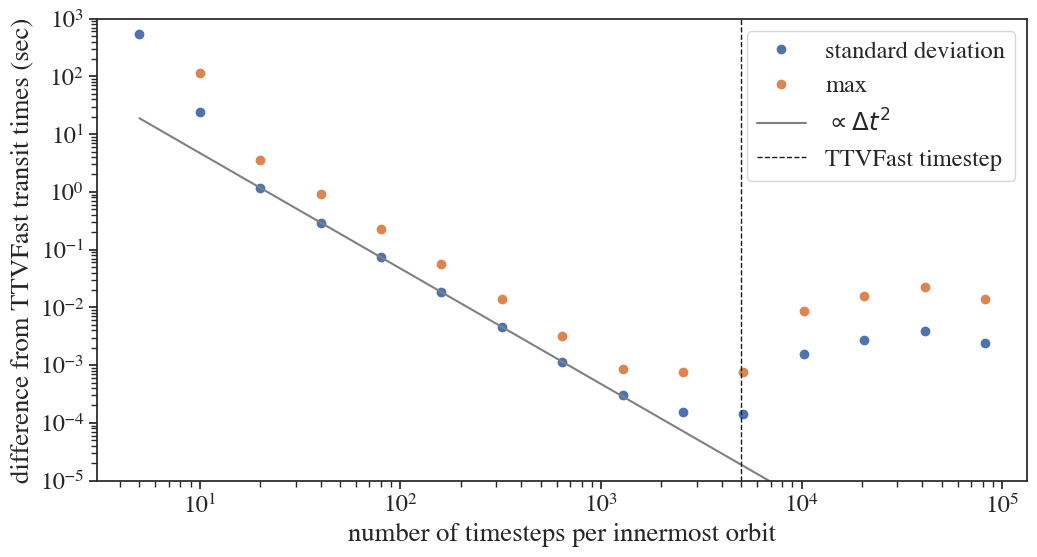

In [15]:
plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-5, 1e3)
plt.ylabel("difference from TTVFast transit times (sec)")
plt.xlabel("number of timesteps per innermost orbit")
plt.plot(p_init[0]/dt_arr, dt_std*86400, 'o', label='standard deviation')
plt.plot(p_init[0]/dt_arr, dt_max*86400, 'o', label='max')
plt.plot(p_init[0]/dt_arr, 86400*dt_std[2]*(dt_arr/dt_arr[2])**(2.), label='$\propto \Delta t^2$', color='gray')
plt.axvline(x=5e3, label='TTVFast timestep', color='k', lw=1, ls='dashed')
plt.legend(loc='best');